In [1]:
# Append MEDSAM folder
import sys
sys.path.append('/home/lavic-3080/mestrado-carlos/masters-degree/data/vess-map')
from vess_map_dataset_medsam import VessMapDataset
sys.path.append('/home/lavic-3080/mestrado-carlos/masters-degree/MedSAM')
from segment_anything import sam_model_registry

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import monai
from segment_anything import sam_model_registry

import matplotlib.pyplot as plt

In [2]:
# Dataloaders
image_dir = '/home/lavic-3080/mestrado-carlos/masters-degree/data/vess-map/images'
mask_dir = '/home/lavic-3080/mestrado-carlos/masters-degree/data/vess-map/labels'
skeleton_dir = '/home/lavic-3080/mestrado-carlos/masters-degree/data/vess-map/skeletons'

image_size = 1024

# Initialize the dataset
vess_dataset = VessMapDataset(image_dir, mask_dir, skeleton_dir, image_size, apply_transform=True)

# Get the train and test loaders
train_loader, test_loader = vess_dataset.vess_map_dataloader(batch_size=1, train_size=0.8)

In [3]:
# Dice Loss from MONAI
seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction="mean")
# Binary Cross Entropy Loss
ce_loss = nn.BCEWithLogitsLoss(reduction="mean")

In [ ]:
class MedSAM(nn.Module):
    def __init__(self, sam_model):
        super(MedSAM, self).__init__()
        self.image_encoder = sam_model.image_encoder
        self.mask_decoder = sam_model.mask_decoder
        self.prompt_encoder = sam_model.prompt_encoder

        # Freeze prompt encoder parameters
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False

    def forward(self, image, box):
        """
        image (torch.Tensor): Input images of shape (B, 3, H, W)
        box (numpy.ndarray): Bounding boxes of shape (B, 4)
        
        Return torch.Tensor: Predicted masks of shape (B, 1, H, W)
        """
        # Encode the image
        image_embedding = self.image_encoder(image)  # (B, embed_dim, H', W')

        # Prepare bounding boxes
        box_torch = torch.as_tensor(box, dtype=torch.float32, device=image.device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :]  # (B, 1, 4)

        # Encode the prompts (bounding boxes)
        sparse_embeddings, dense_embeddings = self.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )

        # Decode the masks
        low_res_masks, _ = self.mask_decoder(
            image_embeddings=image_embedding,              # (B, embed_dim, H', W')
            image_pe=self.prompt_encoder.get_dense_pe(),   # (1, embed_dim, H', W')
            sparse_prompt_embeddings=sparse_embeddings,    # (B, num_prompts, embed_dim)
            dense_prompt_embeddings=dense_embeddings,      # (B, embed_dim, H', W')
            multimask_output=False,
        )

        # Upsample masks to original image size
        ori_res_masks = F.interpolate(
            low_res_masks,
            size=(image.shape[2], image.shape[3]),
            mode="bilinear",
            align_corners=False,
        )

        return ori_res_masks

In [5]:
# MEDSAM MODEL
MedSAM_CKPT_PATH = "/home/lavic-3080/mestrado-carlos/masters-degree/MedSAM/work_dir/MedSAM/medsam_vit_b.pth"
device = "cuda:0"
medsam_model_trained = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model_trained = medsam_model_trained.to(device)
medsam_model_trained.train()

# Wrap the SAM model with MedSAM
medsam_model = MedSAM(medsam_model_trained)
medsam_model.to(device)
medsam_model.train()  # Set to training mode

/home/lavic-3080/mestrado-carlos/masters-degree/MedSAM/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_locati

MedSAM(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
   

In [6]:
# Only train the image encoder and mask decoder
optimizer = optim.AdamW(
    [
        {'params': medsam_model.image_encoder.parameters()},
        {'params': medsam_model.mask_decoder.parameters()}
    ],
    lr=1e-4, weight_decay=0.01
)

# Freeze prompt encoder parameters
for param in medsam_model.prompt_encoder.parameters():
    param.requires_grad = False

Epoch 1/2: 100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


Epoch 1/2, Loss: 0.3110
Best model saved at epoch 1 with loss 0.3110


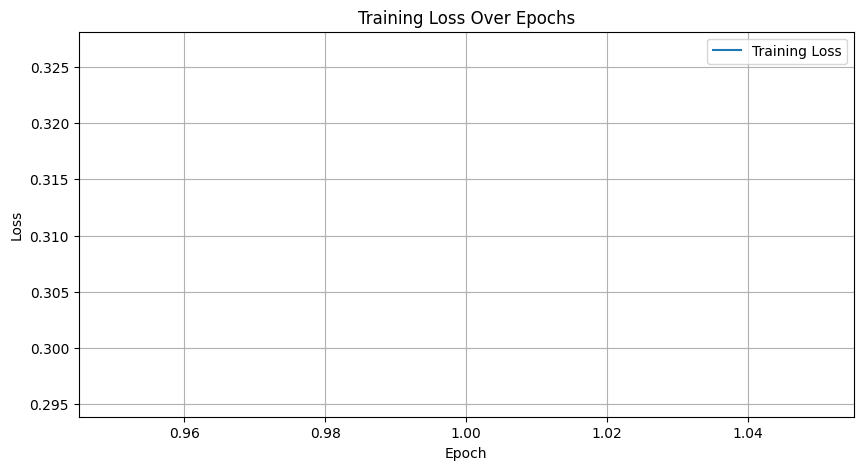

Epoch 2/2: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]


Epoch 2/2, Loss: 0.1897
Best model saved at epoch 2 with loss 0.1897


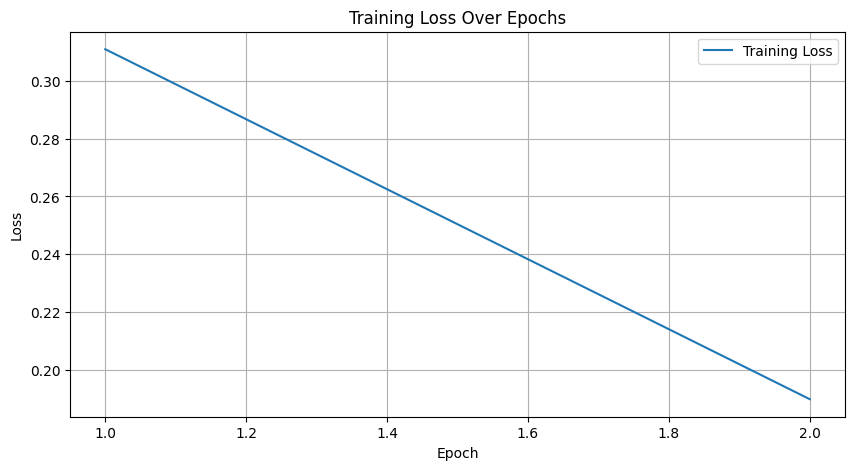

In [ ]:
# Training Loop
num_epochs = 2  # Adjust as needed
losses = []
best_loss = float('inf')

for epoch in range(num_epochs):
    medsam_model.train()
    epoch_loss = 0.0
    for step, (images, masks, skeletons, bboxes) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        optimizer.zero_grad()
        images = images.to(device)      # Shape: (B, 3, 1024, 1024)
        masks = masks.to(device)        # Shape: (B, 1, 1024, 1024)
        bboxes = bboxes.to(device)      # Shape: (B, 4)

        # Convert bounding boxes to numpy
        boxes_np = bboxes.cpu().numpy()

        # Forward pass
        try:
            medsam_pred = medsam_model(images, boxes_np)  # Expected shape: (B, 1, 1024, 1024)
        except Exception as e:
            print(f"Error during forward pass at epoch {epoch+1}, step {step+1}: {e}")
            raise e

        # Compute loss
        loss = seg_loss(medsam_pred, masks) + ce_loss(medsam_pred, masks.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= (step + 1)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(medsam_model.state_dict(), 'medsam_finetuned_vessels_best.pth')
        print(f"Best model saved at epoch {epoch+1} with loss {best_loss:.4f}")

    # Save the latest model aswell
    torch.save(medsam_model.state_dict(), 'medsam_finetuned_vessels_latest.pth')

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch+2), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()